In [1]:
# step 1: Load data, import library
import torch,torchvision
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from __future__ import print_function
import argparse
import torch
import torch.optim as optim
from torch.autograd import Variable

In [2]:
# MNIST Dataset
train_dataset = datasets.MNIST(root='./data/',
         train=True,
         transform=transforms.ToTensor(),
         download=True)

test_dataset = datasets.MNIST(root='./data/',
         train=False,
         transform=transforms.ToTensor())


In [18]:
# Training settings
batch_size = 100

# Data Loader (Input Pipeline)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
         batch_size=batch_size,
         shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
        batch_size=batch_size,
        shuffle=True)

tensor([1, 0, 2, 0, 3, 3, 1, 4, 7, 3, 5, 7, 0, 8, 0, 9, 6, 7, 6, 6, 3, 9, 0, 5,
        6, 2, 9, 6, 5, 6, 5, 2, 9, 5, 9, 9, 2, 9, 6, 1, 9, 1, 6, 9, 0, 6, 3, 7,
        2, 9, 6, 4, 7, 2, 4, 4, 7, 8, 9, 9, 9, 1, 1, 5, 2, 5, 1, 1, 3, 5, 6, 5,
        3, 5, 0, 7, 5, 6, 7, 5, 0, 6, 4, 6, 7, 7, 0, 9, 3, 6, 0, 2, 0, 9, 1, 1,
        4, 2, 1, 3])
torch.Size([100, 1, 28, 28])


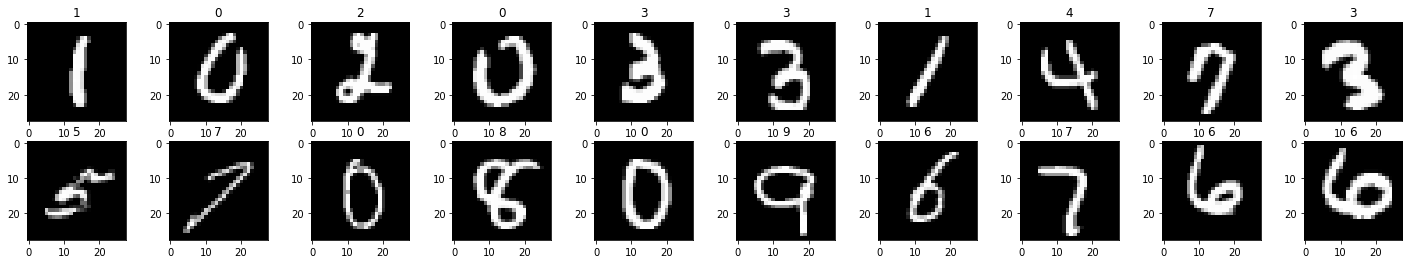

In [19]:
#step 2 :  Preprocessing
#datasets processing
data_out=iter(train_loader)
inputs,labels=data_out.next()
print(labels)
print(inputs.size())

#image processing
fig=plt.figure(figsize=(25,4))
for idx in np.arange(20):
  ax=fig.add_subplot(2,10,idx+1)
  plt.imshow(inputs[idx].reshape(28,28), cmap="gray")
  ax.set_title(labels[idx].item())

In [56]:
class InceptionA(nn.Module):

    def __init__(self, in_channels):
        super(InceptionA, self).__init__()
        self.branch1x1 = nn.Conv2d(in_channels, 16, kernel_size=1)

        self.branch5x5_1 = nn.Conv2d(in_channels, 16, kernel_size=1)
        self.branch5x5_2 = nn.Conv2d(16, 24, kernel_size=5, padding=2)

        self.branch3x3dbl_1 = nn.Conv2d(in_channels, 16, kernel_size=1)
        self.branch3x3dbl_2 = nn.Conv2d(16, 24, kernel_size=3, padding=1)
        self.branch3x3dbl_3 = nn.Conv2d(24, 24, kernel_size=3, padding=1)

        self.branch_pool = nn.Conv2d(in_channels, 24, kernel_size=1)

    def forward(self, x):
        branch1x1 = self.branch1x1(x)

        branch5x5 = self.branch5x5_1(x)
        branch5x5 = self.branch5x5_2(branch5x5)

        branch3x3dbl = self.branch3x3dbl_1(x)
        branch3x3dbl = self.branch3x3dbl_2(branch3x3dbl)
        branch3x3dbl = self.branch3x3dbl_3(branch3x3dbl)

        branch_pool = F.avg_pool2d(x, kernel_size=3, stride=1, padding=1)
        branch_pool = self.branch_pool(branch_pool)

        outputs = [branch1x1, branch5x5, branch3x3dbl, branch_pool]
        return torch.cat(outputs, 1)


class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(88, 20, kernel_size=5)

        self.incept1 = InceptionA(in_channels=10)
        self.incept2 = InceptionA(in_channels=20)

        self.mp = nn.MaxPool2d(2)
        self.fc = nn.Linear(1408, 10)
        # Dropout(0.2)
        self.dropout1 = nn.Dropout(0.2)
        self.dropout2 = nn.Dropout(0.2)

    def forward(self, x):
        in_size = x.size(0)
        x = F.relu(self.mp(self.conv1(x)))
        x = self.incept1(x)
        x = self.dropout1(x) # Dropout(0.2)
        x = F.relu(self.mp(self.conv2(x)))
        x = self.incept2(x)
        x = self.dropout2(x) # Dropout(0.2)
        x = x.view(in_size, -1)  # flatten the tensor
        x = self.fc(x)
        return F.log_softmax(x)
    
    def validation_step(self, x):
      self.log('val_loss', loss)


In [ ]:
!pip install pytorch-lightning torchtext

In [55]:
import pytorch_lightning as pl 
from pytorch_lightning.callbacks import EarlyStopping


In [57]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = Net().to(device)
print(model)

Net(
  (conv1): Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(88, 20, kernel_size=(5, 5), stride=(1, 1))
  (incept1): InceptionA(
    (branch1x1): Conv2d(10, 16, kernel_size=(1, 1), stride=(1, 1))
    (branch5x5_1): Conv2d(10, 16, kernel_size=(1, 1), stride=(1, 1))
    (branch5x5_2): Conv2d(16, 24, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (branch3x3dbl_1): Conv2d(10, 16, kernel_size=(1, 1), stride=(1, 1))
    (branch3x3dbl_2): Conv2d(16, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (branch3x3dbl_3): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (branch_pool): Conv2d(10, 24, kernel_size=(1, 1), stride=(1, 1))
  )
  (incept2): InceptionA(
    (branch1x1): Conv2d(20, 16, kernel_size=(1, 1), stride=(1, 1))
    (branch5x5_1): Conv2d(20, 16, kernel_size=(1, 1), stride=(1, 1))
    (branch5x5_2): Conv2d(16, 24, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (branch3x3dbl_1): Conv2d(20, 16, kernel_size=(1, 1), stri

In [36]:
#step 4 training
criterion = nn.CrossEntropyLoss() 
optimizer = torch.optim.Adam(model.parameters(),lr=0.001)
epochs = 10
running_loss_history = []
running_corrects_history = []
val_running_loss_history = []
val_running_corrects_history = []

for e in range(epochs):
  
  running_loss = 0.0
  running_corrects = 0.0
  val_running_loss = 0.0
  val_running_corrects = 0.0
  
  for inputs, labels in train_loader:
    inputs = inputs.to(device)
    labels = labels.to(device)
    #inputs = inputs.view(inputs.shape[0], -1)
    outputs = model(inputs)
    loss = criterion(outputs, labels)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    _, preds = torch.max(outputs, 1)
    running_loss += loss.item()
    running_corrects += torch.sum(preds == labels.data).cpu()
    # numpy不能處理CUDA tensor，要先將GPU中的tensor複製到CPU内存中，再傳給numpy。

# 最後一圈後做else
  else:
    with torch.no_grad():
      for val_inputs, val_labels in test_loader:
        #val_inputs = val_inputs.view(val_inputs.shape[0], -1)
        val_inputs = val_inputs.to(device)
        val_labels = val_labels.to(device)
        val_outputs = model(val_inputs)
        val_loss = criterion(val_outputs, val_labels)
        
        _, val_preds = torch.max(val_outputs, 1)
        val_running_loss += val_loss.item()
        val_running_corrects += torch.sum(val_preds == val_labels.data).cpu()
        # numpy不能處理CUDA tensor，要先將GPU中的tensor複製到CPU内存中，再傳給numpy。
      
    # 統計用
    epoch_loss = running_loss/len(train_loader)
    epoch_acc = running_corrects.float()/ len(train_loader)
    running_loss_history.append(epoch_loss)
    running_corrects_history.append(epoch_acc)
    
    val_epoch_loss = val_running_loss/len(test_loader)
    val_epoch_acc = val_running_corrects.float()/ len(test_loader)
    val_running_loss_history.append(val_epoch_loss)
    val_running_corrects_history.append(val_epoch_acc)
    print('epoch :', (e+1))
    print('training loss: {:.4f}, acc {:.4f} '.format(epoch_loss, epoch_acc.item()))
    print('validation loss: {:.4f}, validation acc {:.4f} '.format(val_epoch_loss, val_epoch_acc.item()))


<ipython-input-33-9739a07e4efe>:58: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


epoch : 1
training loss: 0.0446, acc 98.6167 
validation loss: 0.0388, validation acc 98.7200 
epoch : 2
training loss: 0.0375, acc 98.7950 
validation loss: 0.0356, validation acc 98.9900 
epoch : 3
training loss: 0.0342, acc 98.9650 
validation loss: 0.0610, validation acc 98.1100 
epoch : 4
training loss: 0.0331, acc 98.9867 
validation loss: 0.0340, validation acc 98.9100 
epoch : 5
training loss: 0.0299, acc 99.0317 
validation loss: 0.0316, validation acc 99.0300 
epoch : 6
training loss: 0.0292, acc 99.0567 
validation loss: 0.0336, validation acc 98.8600 
epoch : 7
training loss: 0.0249, acc 99.1900 
validation loss: 0.0355, validation acc 98.9200 
epoch : 8
training loss: 0.0254, acc 99.1883 
validation loss: 0.0363, validation acc 98.9400 
epoch : 9
training loss: 0.0221, acc 99.2650 
validation loss: 0.0287, validation acc 99.1800 
epoch : 10
training loss: 0.0210, acc 99.3317 
validation loss: 0.0360, validation acc 98.9000 


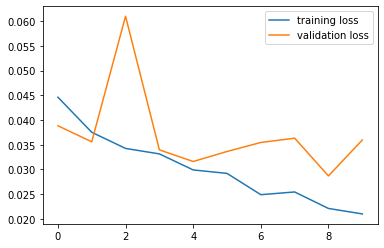

In [37]:
plt.plot(running_loss_history, label='training loss')
plt.plot(val_running_loss_history, label='validation loss')
plt.legend()
plt.show()

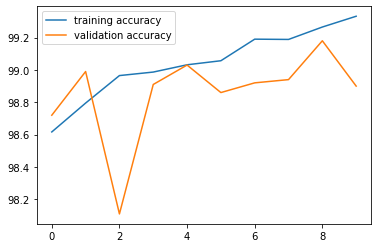

In [38]:
plt.plot(running_corrects_history, label='training accuracy')
plt.plot(val_running_corrects_history, label='validation accuracy')
plt.legend()
plt.show()

## FashionMNIST

In [25]:
#load FashionMNIST dataset
transform=transforms.Compose([transforms.Resize((28,28)),
               transforms.ToTensor(),
               transforms.Normalize((0.5,),(0.5,))               
               ])
train_dataset=datasets.FashionMNIST(root='./data',train=True,download=True,transform=transform)
validation_dataset=datasets.FashionMNIST(root='./data',train=False,download=True,transform=transform)

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



tensor([4, 1, 4, 2, 7, 5, 0, 8, 1, 0, 6, 4, 0, 6, 1, 0, 1, 5, 8, 6, 1, 4, 0, 6,
        6, 2, 0, 7, 3, 5, 0, 9, 7, 0, 8, 0, 7, 1, 4, 2, 7, 5, 0, 5, 5, 2, 4, 0,
        3, 6, 8, 3, 9, 1, 7, 6, 8, 8, 6, 9, 4, 5, 6, 9, 6, 1, 3, 7, 8, 1, 9, 8,
        1, 0, 3, 1, 2, 6, 9, 5, 9, 2, 1, 8, 2, 5, 2, 7, 6, 1, 2, 5, 0, 3, 9, 2,
        7, 2, 9, 7])
torch.Size([100, 1, 28, 28])


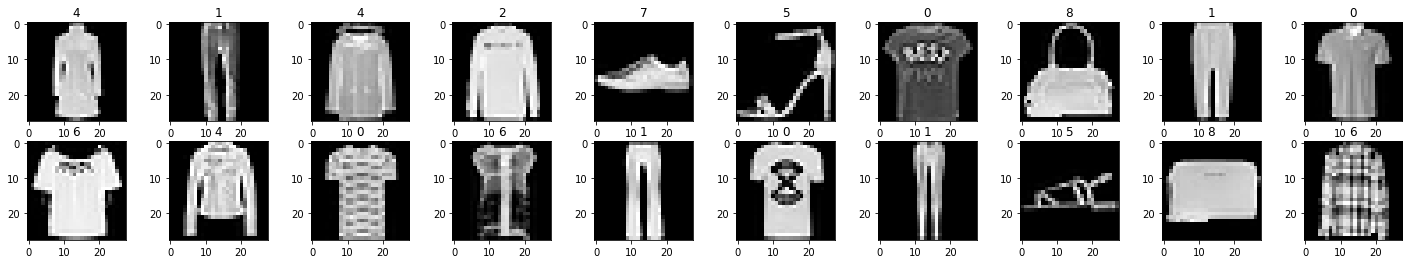

In [26]:
#step 2 :  Preprocessing
#datasets processing
training_loader=torch.utils.data.DataLoader(train_dataset, batch_size=100,shuffle=True)
validation_loader=torch.utils.data.DataLoader(validation_dataset, batch_size=100,shuffle=True)

data_out=iter(training_loader)
inputs,labels=data_out.next()
print(labels)
print(inputs.size())

#image processing
fig=plt.figure(figsize=(25,4))
for idx in np.arange(20):
  ax=fig.add_subplot(2,10,idx+1)
  plt.imshow(inputs[idx].reshape(28,28), cmap="gray")
  ax.set_title(labels[idx].item())

In [39]:
#step 4 training
criterion=nn.CrossEntropyLoss() 
optimizer = torch.optim.Adam(model.parameters(),lr=0.0001)
epochs = 5
running_loss_history = []
running_corrects_history = []
val_running_loss_history = []
val_running_corrects_history = []

for e in range(epochs):
  
  running_loss = 0.0
  running_corrects = 0.0
  val_running_loss = 0.0
  val_running_corrects = 0.0
  
  for inputs, labels in training_loader:
    inputs = inputs.to(device)
    labels = labels.to(device)
    #inputs = inputs.view(inputs.shape[0], -1)
    outputs = model(inputs)
    loss = criterion(outputs, labels)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    _, preds = torch.max(outputs, 1)
    running_loss += loss.item()
    running_corrects += torch.sum(preds == labels.data).cpu()


# 最後一圈後做else
  else:
    with torch.no_grad():
      for val_inputs, val_labels in validation_loader:
        #val_inputs = val_inputs.view(val_inputs.shape[0], -1)
        val_inputs = val_inputs.to(device)
        val_labels = val_labels.to(device)
        val_outputs = model(val_inputs)
        val_loss = criterion(val_outputs, val_labels)
        
        _, val_preds = torch.max(val_outputs, 1)
        val_running_loss += val_loss.item()
        val_running_corrects += torch.sum(val_preds == val_labels.data).cpu()
      
    # 統計用
    epoch_loss = running_loss/len(training_loader)
    epoch_acc = running_corrects.float()/ len(training_loader)
    running_loss_history.append(epoch_loss)
    running_corrects_history.append(epoch_acc)
    
    val_epoch_loss = val_running_loss/len(validation_loader)
    val_epoch_acc = val_running_corrects.float()/ len(validation_loader)
    val_running_loss_history.append(val_epoch_loss)
    val_running_corrects_history.append(val_epoch_acc)
    print('epoch :', (e+1))
    print('training loss: {:.4f}, acc {:.4f} '.format(epoch_loss, epoch_acc.item()))
    print('validation loss: {:.4f}, validation acc {:.4f} '.format(val_epoch_loss, val_epoch_acc.item()))


<ipython-input-33-9739a07e4efe>:58: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


epoch : 1
training loss: 2.3942, acc 53.4033 
validation loss: 0.9721, validation acc 67.3400 
epoch : 2
training loss: 0.8119, acc 72.1267 
validation loss: 0.7258, validation acc 74.8100 
epoch : 3
training loss: 0.6502, acc 77.0117 
validation loss: 0.6284, validation acc 77.6200 
epoch : 4
training loss: 0.5700, acc 79.3650 
validation loss: 0.5698, validation acc 79.4400 
epoch : 5
training loss: 0.5191, acc 81.3467 
validation loss: 0.5240, validation acc 81.2700 


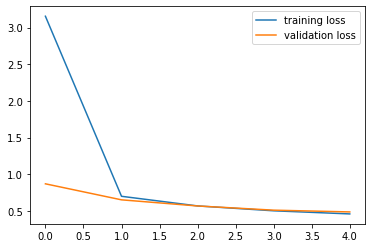

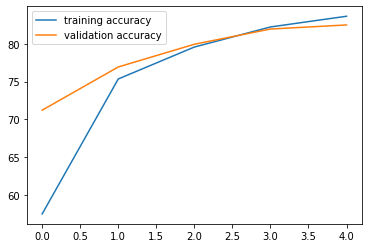

In [29]:
plt.plot(running_loss_history, label='training loss')
plt.plot(val_running_loss_history, label='validation loss')
plt.legend()
plt.show()
plt.plot(running_corrects_history, label='training accuracy')
plt.plot(val_running_corrects_history, label='validation accuracy')
plt.legend()
plt.show()